In [1]:
import sys
import os
from tempfile import mkdtemp

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')


from biosimulator_processes.processes.amici_process import UtcAmici
from biosimulator_processes.processes.copasi_process import UtcCopasi

from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.helpers import plot_utc_outputs

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [2]:
omex_dir = './examples/sbml-core/Elowitz-Nature-2000-Repressilator'
omex_fp = omex_dir + '.omex'
sbml_fp = os.path.join(omex_dir, 'BIOMD0000000012_url.xml')
sedml_fp = os.path.join(omex_dir, 'simulation.sedml')
reports_path = os.path.join(omex_dir, 'reports.h5')

Configure and create an Amici UTC instance using just the archive filepath.

In [3]:
utc_amici = UtcAmici(config={'model': {'model_source': omex_dir + '.omex'}})

2024-05-29 17:16:16.451 - amici.sbml_import - INFO - Finished importing SBML                         (3.75E-02s)
2024-05-29 17:16:16.498 - amici.sbml_import - INFO - Finished processing SBML observables            (4.37E-02s)
2024-05-29 17:16:16.502 - amici.sbml_import - INFO - Finished processing SBML event observables      (7.50E-07s)
2024-05-29 17:16:16.525 - amici.de_model - INFO - Finished computing xdot                            (3.23E-03s)
2024-05-29 17:16:16.532 - amici.de_model - INFO - Finished computing x0                              (2.88E-03s)
2024-05-29 17:16:16.550 - amici.de_model - INFO - Finished computing w                               (1.56E-02s)
2024-05-29 17:16:17.197 - amici.de_export - INFO - Finished generating cpp code                      (6.42E-01s)
2024-05-29 17:16:26.019 - amici.de_export - INFO - Finished compiling cpp code                       (8.82E+00s)


In [4]:
# t range parameters set via sedml introspection within archive contents:
utc_amici.t[0], utc_amici.t[-1], utc_amici.duration, utc_amici.step_size, utc_amici.num_steps

(400.0, 600.0, 600, 1.0, 600)

In [5]:
# you can verify this time config against the SEDML file
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

<?xml version="1.0" encoding="UTF-8"?>
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version3" level="1" version="3"
  xmlns:sbml="http://www.sbml.org/sbml/level2/version3">
  <listOfModels>
    <model id="model" language="urn:sedml:language:sbml" source="BIOMD0000000012_url.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfSpecies/sbml:species[@id='PX']/@initialAmount" newValue="0"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="simulation" initialTime="0" outputStartTime="400" outputEndTime="1000" numberOfPoints="600">
      <algorithm kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task" modelReference="model" simulationReference="simulation"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="data_gen_time" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> var_time </ci>
      </ma

In [6]:
# run the amici utc simulation with the interface's update method:
amici_results = utc_amici.update()

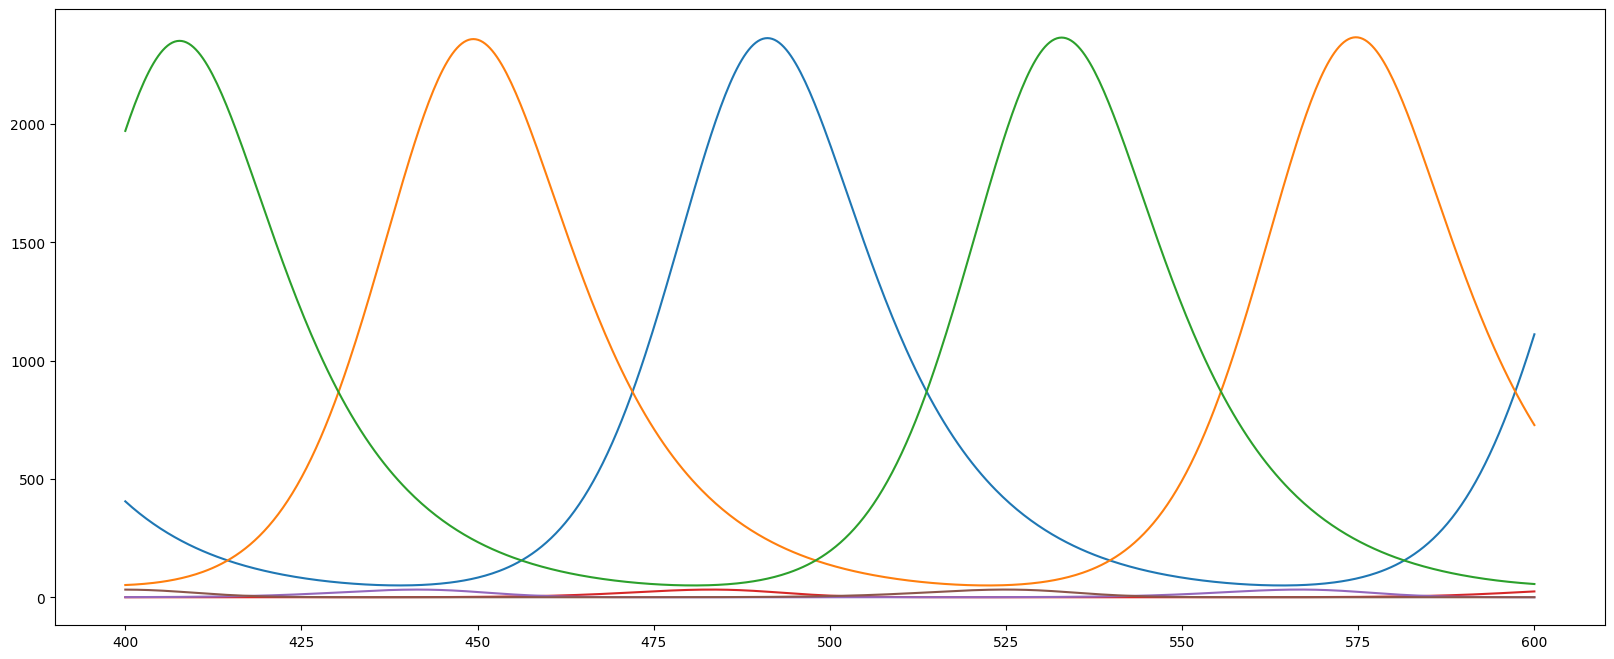

In [7]:
# use built-in plot to plot results
utc_amici.plot_results()

Now create a `CopasiUtc` instance and extract/visualize results as with the amici process.

In [8]:
utc_amici.step_size

1.0

In [9]:
utc_copasi = UtcCopasi(config={'model': {'model_source': omex_dir + '.omex'}})

In [10]:
copasi_results = utc_copasi.update()

copasi_results

{'time': array([400.        , 400.33388982, 400.66777963, 401.00166945,
        401.33555927, 401.66944908, 402.0033389 , 402.33722871,
        402.67111853, 403.00500835, 403.33889816, 403.67278798,
        404.0066778 , 404.34056761, 404.67445743, 405.00834725,
        405.34223706, 405.67612688, 406.01001669, 406.34390651,
        406.67779633, 407.01168614, 407.34557596, 407.67946578,
        408.01335559, 408.34724541, 408.68113523, 409.01502504,
        409.34891486, 409.68280467, 410.01669449, 410.35058431,
        410.68447412, 411.01836394, 411.35225376, 411.68614357,
        412.02003339, 412.35392321, 412.68781302, 413.02170284,
        413.35559265, 413.68948247, 414.02337229, 414.3572621 ,
        414.69115192, 415.02504174, 415.35893155, 415.69282137,
        416.02671119, 416.360601  , 416.69449082, 417.02838063,
        417.36227045, 417.69616027, 418.03005008, 418.3639399 ,
        418.69782972, 419.03171953, 419.36560935, 419.69949917,
        420.03338898, 420.367278

In [11]:
utc_copasi.floating_species_list

['PX', 'PY', 'PZ', 'X', 'Y', 'Z']

In [16]:
utc_copasi.num_steps, list(utc_copasi._results['floating_species'].values())[1].shape, utc_copasi.t.shape

(600, (201,), (600,))

In [13]:
utc_copasi.t[-1]

600.0

In [14]:
from basico import * 
sbml_species_mapping = get_species(m=utc_copasi.simulator)[['sbml_id']].to_dict()['sbml_id']

sbml_species_mapping

{'LacI protein': 'PX',
 'TetR protein': 'PY',
 'cI protein': 'PZ',
 'LacI mRNA': 'X',
 'TetR mRNA': 'Y',
 'cI mRNA': 'Z'}

In [15]:
utc_copasi.plot_results()

ValueError: All arrays must be of the same length

<Figure size 2000x800 with 0 Axes>

Finally, optionally generate a "ground truth" which we include in the comparison. The default source for ground-truth data is via uploading an omex archive as model source. The report outputs must be included in the archive.

In [ ]:
# Generate comparison matrix from ground truth
from biosimulator_processes.api.compare import generate_comparison

In [ ]:
published_results = read_report_outputs(reports_path)

type(published_results)

In [ ]:
published_results.data

In [ ]:
published_species_outputs = []
for report_output in published_results.data:
    if not report_output.dataset_label.lower() == 'time':
        published_species_outputs.append({report_output.dataset_label: report_output.data})

In [ ]:
published_species_outputs

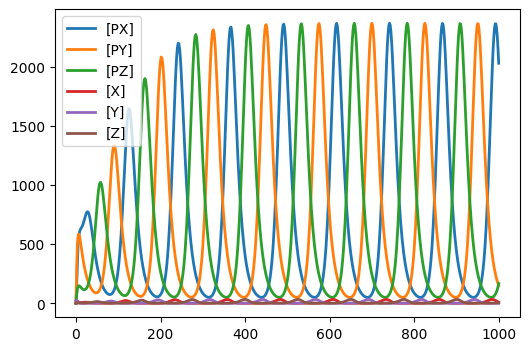

In [28]:
import tellurium as te 

r = te.loadSBMLModel(sbml_fp)
# simulate from 0 to 50 with 1001 points
s = r.simulate(start=0, end=1000, steps=600)
# plot the results
r.plot(s);

In [38]:
outputs = {'floating_species': {}}
for i, row in enumerate(s.transpose()):
    if i < 1:
        outputs['time'] = row 
    else:
        for name in r.getFloatingSpeciesIds():
            outputs['floating_species'][name] = row 

In [40]:
outputs['floating_species'].keys()

dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])

In [19]:
s.shape

(1001, 7)